In [1]:
from util import *
from matplotlib import pyplot as plt

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

Using Theano backend.


In [2]:
xls_file, hub_name, weather_station, load_station = "test_data.xlsx", "MICHIGAN.HUB", "Detroit", "north"

In [3]:
df = parse_hub_data(hub_name=hub_name, xls_file=xls_file, 
                    weather_station=weather_station, load_station=load_station)

In [4]:
def RNN_model(df):
    
    exogenous = extract_exogenous_variables(df)
    timeseries_profiles = extract_lagged_series(df, lags=[24]) 
    labels = df["rtlmp"]
    
    ts, ex, truth = clean_data(timeseries_profiles, exogenous, labels)
    
    ts_train, ts_test, ex_train, ex_test, truth_train, truth_test, ts_scale, exo_scale, labels_scale = \
    get_standardized_matrices(ts, ex, truth)
    
    model = build_RNN(ex_train.shape[1])
    model = train_RNN(model, ts_train, ex_train, truth_train)
    yhat1, yhat2 = model.predict([ts_test, ex_test], batch_size=batch_size)
    
    return labels_scale.inverse_transform(yhat2), labels_scale.inverse_transform(truth_test) 

In [5]:
def ANN_model(df):

    exogenous = extract_exogenous_variables(df)

    lags = [24, 25, 26, (7 * 24), (7 * 24) + 1, (7 * 24) -
            1, 14 * 24, 21 * 24, 28 * 24]
    timeseries_profiles = extract_lagged_series(df, lags=lags)

    labels = df["rtlmp"]

    ts, ex, truth = clean_data(timeseries_profiles, exogenous, labels)

    (ts_train, ts_test, ex_train, ex_test, truth_train, truth_test, ts_scale,
     exo_scale, labels_scale) = get_standardized_matrices(ts, ex, truth)

    ts_train, ts_test = np.squeeze(ts_train), np.squeeze(ts_test)

    model = build_ANN(exogenous.shape[1], timeseries_profiles.shape[1])

    model.fit(np.concatenate([ts_train, ex_train], axis=1), truth_train)

    yhat = labels_scale.inverse_transform(
        model.predict(np.concatenate([ts_test, ex_test], axis=1)))

    return yhat

In [30]:
def Linear_model(df):
    
    from sklearn.linear_model import RidgeCV
    ridge = RidgeCV()
    
    exogenous = extract_exogenous_variables(df)
    
    lags = [24, 25, 26, (7*24), (7*24)+1, (7*24)-1, 14*24, 21*24, 28*24]
    timeseries_profiles = extract_lagged_series(df, lags=lags) 

    labels = df["rtlmp"]

    ts, ex, truth = clean_data(timeseries_profiles, exogenous, labels)

    ts_train, ts_test, ex_train, ex_test, truth_train, truth_test, ts_scale, exo_scale, labels_scale = \
        get_standardized_matrices(ts, ex, truth)

    ts_train, ts_test = np.squeeze(ts_train), np.squeeze(ts_test)
    
    ridge.fit(np.concatenate([ts_train, ex_train], axis=1), truth_train)
    
    return labels_scale.inverse_transform(ridge.predict(np.concatenate([ts_test, ex_test], axis=1)))

In [71]:
def mape(truth, forecast):
    
    return np.sum(np.abs(truth-forecast.ravel()) / np.mean(truth)) * (100 /truth.size)
    

In [31]:
y_RNN, truth = RNN_model(df)
y_ANN = ANN_model(df)
y_Linear = Linear_model(df)

Training
Epoch 1/1
8000/8000 [==============================] - 1s - loss: 0.1883 - lstm_predict_loss: 0.0710 - main_output_loss: 0.0234     
Epoch 1/1
8000/8000 [==============================] - 1s - loss: 0.0617 - lstm_predict_loss: 0.0156 - main_output_loss: 0.0092     
Epoch 1/1
8000/8000 [==============================] - 1s - loss: 0.0544 - lstm_predict_loss: 0.0121 - main_output_loss: 0.0085     
Epoch 1/1
8000/8000 [==============================] - 1s - loss: 0.0512 - lstm_predict_loss: 0.0113 - main_output_loss: 0.0080     
Epoch 1/1
8000/8000 [==============================] - 1s - loss: 0.0491 - lstm_predict_loss: 0.0106 - main_output_loss: 0.0077     
Epoch 1/1
8000/8000 [==============================] - 1s - loss: 0.0477 - lstm_predict_loss: 0.0101 - main_output_loss: 0.0075     
Epoch 1/1
8000/8000 [==============================] - 1s - loss: 0.0467 - lstm_predict_loss: 0.0097 - main_output_loss: 0.0074     
Epoch 1/1
8000/8000 [==============================] - 1s - 

In [133]:
print(mape(truth, y_RNN))
print(mape(truth, y_ANN))
print(mape(truth, y_Linear))

20.5976794366
34.3378115238
34.792644506


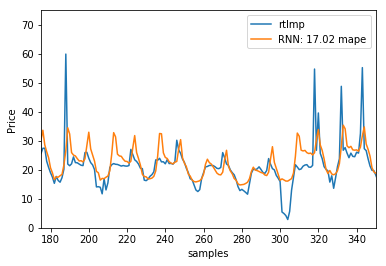

In [145]:
plt.figure()
idx1 = 175
idx2 = 350
plt.plot(truth, label="rtlmp")
plt.plot(y_RNN, label="RNN: {0:.2f} mape".format(mape(truth[idx1:idx2], y_RNN[idx1:idx2])))
# plt.plot(y_ANN, label="ANN: {0:.2f} mape".format(mape(truth[idx1:idx2], y_ANN[idx1:idx2])))

plt.xlim(idx1,idx2)
plt.ylim(0,75)
plt.xlabel("samples")
plt.ylabel("Price")
plt.legend()

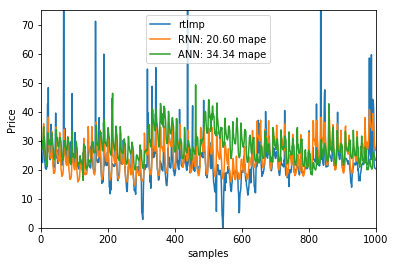

In [144]:
plt.figure()
idx1 = 0
idx2 = 1000
plt.plot(truth, label="rtlmp")
plt.plot(y_RNN, label="RNN: {0:.2f} mape".format(mape(truth[idx1:idx2], y_RNN[idx1:idx2])))
plt.plot(y_ANN, label="ANN: {0:.2f} mape".format(mape(truth[idx1:idx2], y_ANN[idx1:idx2])))

plt.xlim(idx1,idx2)
plt.ylim(0,75)
plt.xlabel("samples")
plt.ylabel("Price")
plt.legend()